In [2]:
using LinearAlgebra, Plots, DifferentialEquations, ForwardDiff, ProgressLogging

In [3]:
w2 = 0.01
import NaNMath
θ = [1.0, 0.0, 1.0]

k(x) = -1x

g = [1.0, 0.0]

Φ(x::AbstractVector, u::AbstractVector) = [
    u[1]   u[2]  0 ;
    0           0     u[3]
]


function L(x::AbstractVector,u::AbstractVector,λ::AbstractVector)
  (
    0.5*dot(u,u)                      # ½‖u‖²
  - w2*(NaNMath.log(u[2]+1) + NaNMath.log(u[3]+0.1))                      # log barrier
  + dot(λ, k(x) - (Φ(x,u)*θ + g))           # dual term  ⟨λ, …⟩
  )
end
function L_flat(v, n_x, n_u)
    x      = @view v[1:n_x]
    u      = @view v[n_x+1 : n_x+n_u]
    λ      = @view v[n_x+n_u+1 : end]
    return L(x, u, λ)
end

L_flat (generic function with 1 method)

In [4]:
x = [0.0, -1.0]; n_x = length(x)
λ = [0.0, 0.0]; n_λ = length(λ)
u = [1.0, 0.9, 1.0]; n_u = length(u)

v = vcat(x, u, λ)
f = v -> L_flat(v, n_x, n_u)
cfg = ForwardDiff.HessianConfig(f, v)


ForwardDiff.HessianConfig{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7, Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#11#12", Float64}, ForwardDiff.Dual{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7}, 7}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7}}}(ForwardDiff.JacobianConfig{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7, Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7}}}((Partials(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), Partials(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), Partials(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0), Partials(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0), Partials(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), Partials(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0), Partials(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{var"#11#12", Float64}, Float64, 7}[Dual{ForwardDiff.Tag{var"#11#12", Float64}}(6.81311962772675e-310,6.81311962779e-310,6.8130947652842e-310,6.81309476531896e-310,6.81309476535216e-310,6.81309476214745e-3

In [5]:
function uλ_dot(x,u,λ)
    # Γ = Matrix{Float64}(I, n_u+n_λ, n_u+n_λ)
    H = ForwardDiff.hessian(f, vcat(x,u,λ), cfg)

    H_uλ = H[n_x+1:end, n_x+1:end]
    H_uλ_inv = inv(H_uλ)

    d2Ldxdudλ = H[n_x+1:end,1:n_x]

    dLduλ = ForwardDiff.gradient(f, vcat(x,u,λ))[n_x+1:end]

    term1 = -10*H_uλ_inv *dLduλ

    uff = H_uλ_inv * H_uλ_inv * d2Ldxdudλ * (k(x) - (Φ(x,u)*θ + g))

    return term1 - uff
end

function dudt(v,p,t)
    x = v[1:n_x]
    u      = v[n_x+1 : n_x+n_u]
    λ      = v[n_x+n_u+1 : end]
    duλ      = uλ_dot(x,u, λ)
    dx = Φ(x,u)*θ + g
    return vcat(dx, duλ)
end

prob = ODEProblem(dudt, vcat(x, u, λ), (0.0, 10.0))
@time sol = solve(prob, Tsit5(), progress = true)

  4.386382 seconds (8.54 M allocations: 445.315 MiB, 14.46% gc time, 99.61% compilation time: <1% of which was recompilation)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 51-element Vector{Float64}:
  0.0
  0.00011570092914217561
  0.0012727102205639317
  0.008476997198327297
  0.024401297647229536
  0.04752866376948712
  0.07649214854816414
  0.10931648352601252
  0.15360081645326337
  0.20376852849357963
  ⋮
  7.512131198918623
  7.8325694861622175
  8.15468631097458
  8.476709383414338
  8.798007021400371
  9.11872736185006
  9.439301824156248
  9.760092778737688
 10.0
u: 51-element Vector{Vector{Float64}}:
 [0.0, -1.0, 1.0, 0.9, 1.0, 0.0, 0.0]
 [0.000231254661304365, -0.9998842990736986, 0.9974560515343494, 0.8989682394237128, 0.9999999263490786, -0.0016187425299055672, 0.0011457470829349674]
 [0.0025276780885103312, -0.9987272935485239, 0.972177806206305, 0.8887161944854801, 0.9999911259587398, -0.017688967871563276, 0.012521737270033015]
 [0.01618541482929884, -0.9915240947836829, 0.8211940396721826, 0.8274878383555453, 0.9996165222316066, -0.1131053970643634, 0.08011701

In [6]:
t_vec = 0:0.1:sol.t[end]
τ = zeros(2,length(t_vec))

L_vec = zeros(length(t_vec))

k_vec = zeros(2,length(t_vec))

FOO_vec = zeros(5, length(t_vec))

for (j, t) in enumerate(t_vec)
    u = sol(t)[n_x+1:n_x+n_u]
    ϕ = Φ(sol(t)[1:n_x], u)
    τ[:,j] = ϕ*θ
    L_vec[j] = L_flat(sol(t), n_x, n_u)
    k_vec[:,j] = k(sol(t)[1:n_x])
    FOO_vec[:,j] = ForwardDiff.gradient(f, sol(t))[n_x+1:end]

end

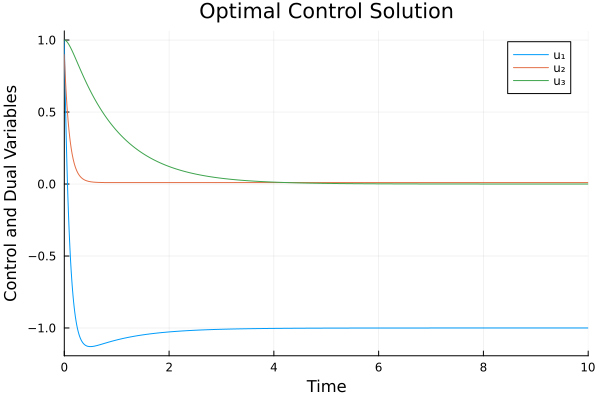

In [11]:
using Plots
plot(sol, idxs= (0,[3,4,5]), xlabel="Time", ylabel="Control and Dual Variables",
     label=["u₁" "u₂" "u₃" ], title="Optimal Control Solution")



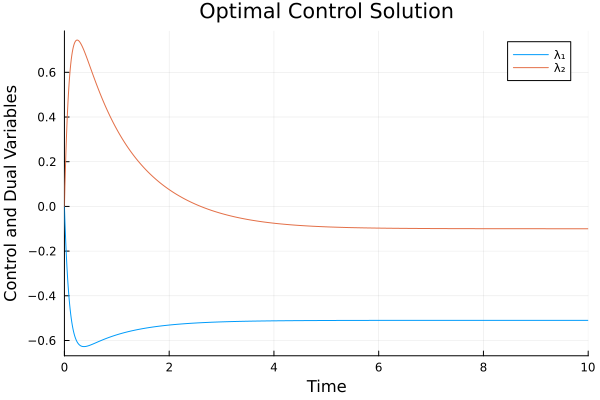

In [64]:
plot(sol, idxs= (0,[6,7]), xlabel="Time", ylabel="Control and Dual Variables",
     label=["λ₁" "λ₂"], title="Optimal Control Solution")

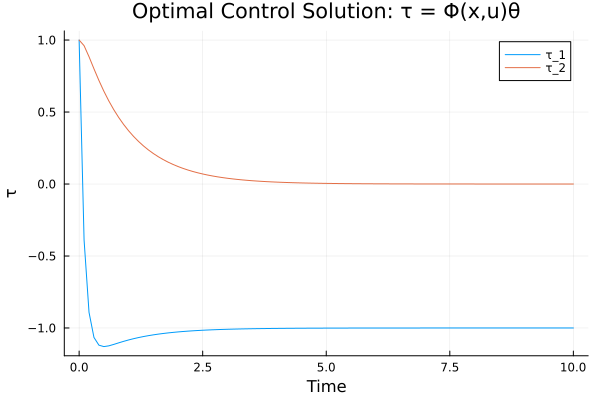

In [12]:
plot(t_vec, τ', label=["τ_1" "τ_2"], xlabel="Time", ylabel="τ",
     title="Optimal Control Solution: τ = Φ(x,u)θ")

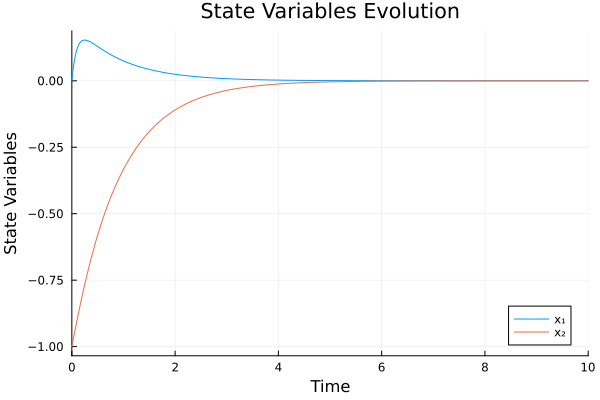

In [13]:
plot(sol, idxs= (0,[1,2]), xlabel="Time", ylabel="State Variables",
     label=["x₁" "x₂"], title="State Variables Evolution")

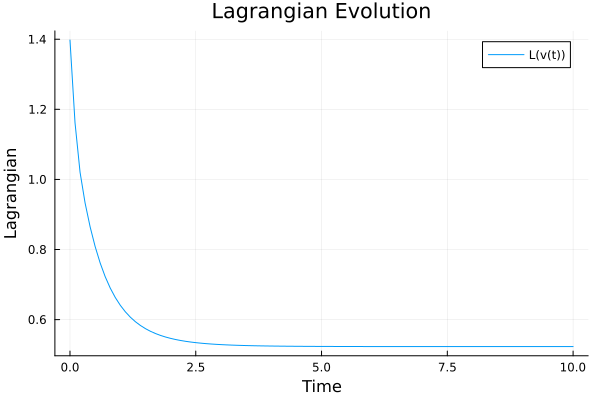

In [14]:
plot(t_vec, L_vec, xlabel="Time", ylabel="Lagrangian",
     title="Lagrangian Evolution", label="L(v(t))")

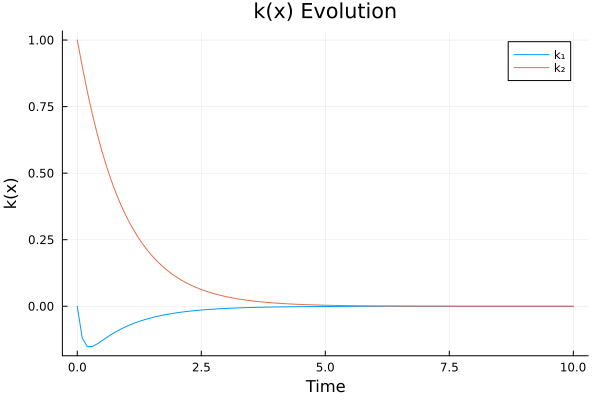

In [15]:
plot(t_vec, k_vec', label=["k₁" "k₂"], xlabel="Time", ylabel="k(x)",
     title="k(x) Evolution")

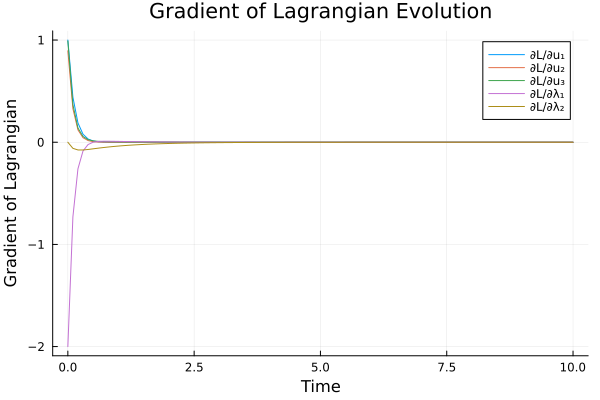

In [16]:
plot(t_vec, FOO_vec', label=["∂L/∂u₁" "∂L/∂u₂" "∂L/∂u₃" "∂L/∂λ₁" "∂L/∂λ₂"],
     xlabel="Time", ylabel="Gradient of Lagrangian",
     title="Gradient of Lagrangian Evolution")